In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 20})
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
Nor_path = "./Dataset/Normal_mixed.csv"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
                "land", "wrong_fragment", "urgent", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
Nor_df = pd.read_csv(Nor_path, header=None,names= col_names, nrows=10000)

In [3]:
Abnor_path = "./Dataset/Abnormal.csv"
Abnor_df = pd.read_csv(Abnor_path, header=None,names= col_names, nrows=10000)

In [4]:
Train_nor, Test_nor = train_test_split(Nor_df, test_size=0.3, random_state=1)
Train_abnor, Test_abnor = train_test_split(Abnor_df, test_size=0.3, random_state=1) 

Train = pd.concat([Train_nor, Train_abnor], ignore_index=True)

Test = pd.concat([Test_nor, Test_abnor], ignore_index=True)

In [5]:
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = MinMaxScaler()

In [6]:
def preprocess(df, is_fit=True):
    # chuyển normal thành 1 và các lớp khác thành 0
    label = df['label'].map(lambda x: 'Abnormal' if x != 'Normal' else x)

    # loại bỏ cột dữ liệu không cần thiết
    df.drop(["land", "wrong_fragment",  "urgent", "rerror_rate",  "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"], axis=1)

    # chia dữ liệu ra số, chữ để tiện xử lý
    numerical_data = df.select_dtypes(exclude='object').values
    categorical_data = df.select_dtypes(include='object').values

    # chỉ fit với dữ liệu train
    if is_fit:
        encoder.fit(categorical_data)

    # chuyển từ dữ liệu chữ sang onehot
    categorical_data = encoder.transform(categorical_data).toarray()

    # nối dữ liệu số và onehot lại
    data = np.concatenate([numerical_data, categorical_data], axis=1)

    # chỉ fit với dữ liệu train
    if is_fit:
        scaler.fit(data)

    # dữ liệu chuẩn hóa về dạng [0, 1]
    data = scaler.transform(data)

    return dict(data=data, label=label)

In [7]:
# xử lý dữ liệu
train = preprocess(Train, True)
test = preprocess(Test, False)

In [8]:
train['data'].shape, test['data'].shape

((14000, 50), (6000, 50))

In [9]:
# chia dữ liệu
Train_nor = train['data'][train['label'] == 'Normal']
Train_abnor = train['data'][train['label'] == 'Abnormal']

Test_nor = test['data'][test['label'] == 'Normal']
Test_abnor = test['data'][test['label'] == 'Abnormal']

## Generate mode Test abnormal data using GAN

In [67]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization

# Define the input dimensions
num_features = Test_abnor.shape[1]  # Exclude the 'attack_type' column
noise_dim = num_features  # Dimensionality of the random noise input

generator = Sequential()
generator.add(Dense(noise_dim, input_shape=(noise_dim,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())

# Define the discriminator network
discriminator = Sequential()
discriminator.add(Dense(noise_dim, input_shape=(num_features,)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Combine the generator and discriminator networks
gan_input = tf.keras.Input(shape=(noise_dim,))
generated_attack = generator(gan_input)
gan_output = discriminator(generated_attack)
gan = tf.keras.Model(gan_input, gan_output)

# Compile the GAN
gan.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
epochs = 200 
batch_size = 128
mu = 0
sigma = 0.001
Src_data = Train_nor

In [69]:
# Training the GAN
for epoch in range(epochs):
    noise = np.random.normal(mu, sigma, size=(batch_size, noise_dim))
    generated_attacks = generator.predict(noise)
    real_attacks = Src_data[np.random.randint(0, Src_data.shape[0], batch_size), :]
    X = np.concatenate([real_attacks, generated_attacks])
    y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    discriminator.trainable = True
    discriminator_loss, discriminator_accuracy = discriminator.train_on_batch(X, y)
    noise = np.random.normal(mu, sigma, size=(batch_size, noise_dim))
    y_gen = np.ones((batch_size, 1))
    discriminator.trainable = False
    gan_loss = gan.train_on_batch(noise, y_gen)

    print(f"Epoch:", epoch+1, "/", epochs, "GAN:", gan_loss)

4/4 [==============================] - 0s 2ms/step
Epoch: 1 / 200 GAN: [0.691667914390564, 0.5234375]
4/4 [==============================] - 0s 2ms/step
Epoch: 2 / 200 GAN: [0.6849076151847839, 0.7890625]
4/4 [==============================] - 0s 2ms/step
Epoch: 3 / 200 GAN: [0.6785184741020203, 0.8203125]
4/4 [==============================] - 0s 2ms/step
Epoch: 4 / 200 GAN: [0.6738284230232239, 0.953125]
4/4 [==============================] - 0s 1ms/step
Epoch: 5 / 200 GAN: [0.6690951585769653, 1.0]
4/4 [==============================] - 0s 2ms/step
Epoch: 6 / 200 GAN: [0.6641311645507812, 1.0]
4/4 [==============================] - 0s 1ms/step
Epoch: 7 / 200 GAN: [0.6610674858093262, 1.0]
4/4 [==============================] - 0s 1ms/step
Epoch: 8 / 200 GAN: [0.656306266784668, 1.0]
4/4 [==============================] - 0s 1ms/step
Epoch: 9 / 200 GAN: [0.652344822883606, 1.0]
4/4 [==============================] - 0s 2ms/step
Epoch: 10 / 200 GAN: [0.6470421552658081, 1.0]
4/4 [====

In [70]:
# Evaluation and Validation
noise = np.random.normal(mu, sigma, size=(20000, noise_dim))
GAN_attacks = generator.predict(noise)

625/625 [==============================] - 1s 888us/step


In [71]:
class Autoencoder(keras.Model):
  def __init__(self, input_dim):
    super(Autoencoder, self).__init__()
    self.encoder = keras.Sequential([
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(8, activation='tanh')
    ])
    self.decoder = keras.Sequential([
      keras.layers.Dense(16, activation='tanh'),
      keras.layers.Dense(32, activation='tanh'),
      keras.layers.Dense(48, activation='tanh'),
      # keras.layers.Dense(128, activation='tanh'),
      keras.layers.Dense(input_dim, activation='sigmoid'),
    ])

  def call(self, x):
    code = self.encoder(x)
    r = self.decoder(code)
    return r

  def get_reconstruction_error(self, x):
    r = self.predict(x)
    return keras.metrics.mean_squared_error(x, r)

  def predict_class(self, x, threshold):
    reconstruction_error = self.get_reconstruction_error(x)
    return np.where(reconstruction_error <= threshold, 'Normal', 'Abnormal')

In [15]:
model = Autoencoder(Train_nor.shape[1])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = keras.losses.MeanSquaredError()
model.compile(optimizer, loss_fn)

In [16]:
model.fit(Train_nor, Train_nor, batch_size=64, epochs=200, shuffle=True)

Epoch 1/200
110/110 [==============================] - 0s 1ms/step - loss: 0.1980
Epoch 2/200
110/110 [==============================] - 0s 1ms/step - loss: 0.1347
Epoch 3/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0862
Epoch 4/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0660
Epoch 5/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 6/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0551
Epoch 7/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 8/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0496
Epoch 9/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 10/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0429
Epoch 11/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 12/200
110/110 [==============================] - 0s 1ms/step - loss: 0.0378
Epoch 13/200


In [17]:
train_normal_re = model.get_reconstruction_error(Train_nor)
train_abnormal_re = model.get_reconstruction_error(Train_abnor)

test_normal_re = model.get_reconstruction_error(Test_nor)
test_abnormal_re = model.get_reconstruction_error(Test_abnor)

94/94 [==============================] - 0s 765us/step


In [18]:
alpha = 0.5
threshold = np.concatenate([train_normal_re, train_abnormal_re]).mean() * alpha
print('Ngưỡng vừa tìm được từ tập train:', threshold)

Ngưỡng vừa tìm được từ tập train: 0.016029616817831993


625/625 [==============================] - 1s 984us/step
Độ chính xác tập khi tái tạo normal tập huấn luyện: 1.0
438/438 [==============================] - 0s 922us/step
Độ chính xác tập huấn luyện: 0.9955
188/188 [==============================] - 0s 920us/step
Độ chính xác tập test: 0.9938333333333333


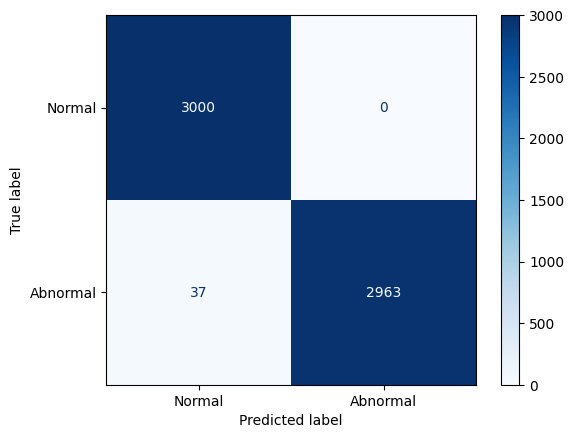

In [60]:
label_predict = model.predict_class(GAN_attacks, threshold)
print('Độ chính xác tập khi tái tạo normal tập huấn luyện', end=': ')
print(accuracy_score(np.full([20000], 'Abnormal'), label_predict))

label_predict = model.predict_class(train['data'], threshold)
print('Độ chính xác tập huấn luyện', end=': ')
print(accuracy_score(train['label'], label_predict))

label_predict = model.predict_class(test['data'], threshold)
print('Độ chính xác tập test', end=': ')
print(accuracy_score(test['label'], label_predict))

labels = ['Normal', 'Abnormal']
matrix = confusion_matrix(test['label'], label_predict)
disp = ConfusionMatrixDisplay(
    confusion_matrix=matrix, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

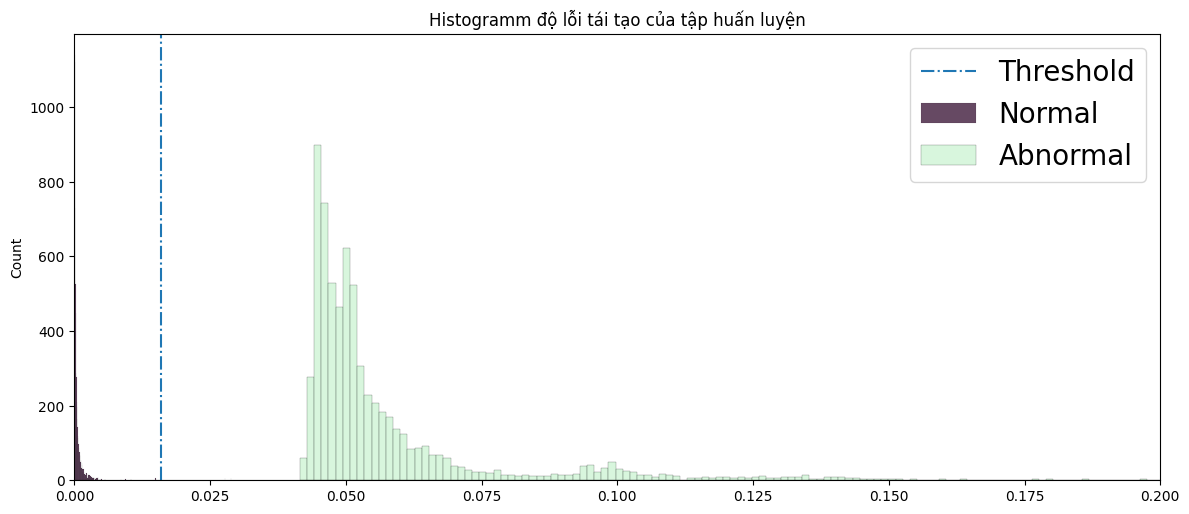

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=train_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=train_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập huấn luyện')
plt.show()

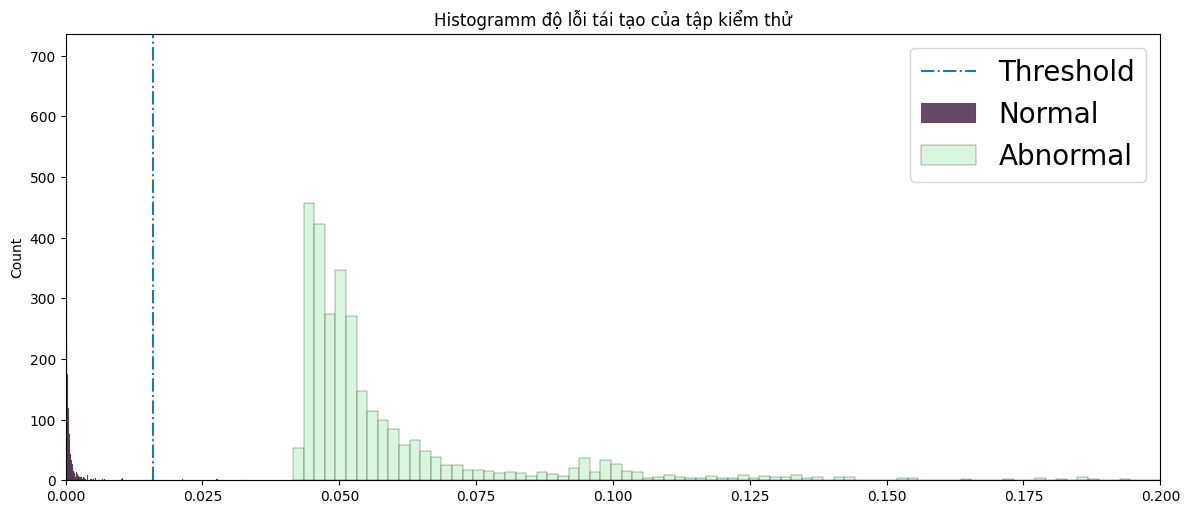

In [21]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=test_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập kiểm thử')
plt.show()

625/625 [==============================] - 1s 1ms/step


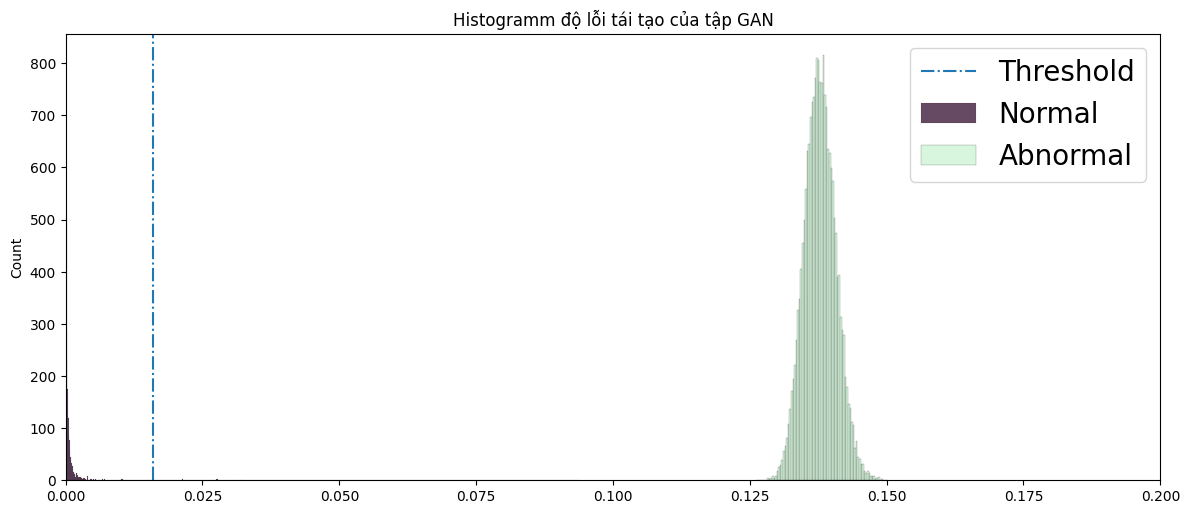

In [72]:
GAN_abnormal_re = model.get_reconstruction_error(GAN_attacks)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(data=test_normal_re, label='Normal', kde=False, ax=ax, color='#330C2F')
sns.histplot(data=GAN_abnormal_re, label='Abnormal', kde=False, ax=ax, color='#CBF3D2')
ax.axvline(threshold, ls='-.', label='Threshold')
ax.legend(loc='best', fontsize=20)
ax.set_xlim([0, 0.2])
fig.tight_layout()
plt.title('Histogramm độ lỗi tái tạo của tập GAN')
plt.show()